In [1]:
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import time

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# split data in 80%/10%/10% train/validation/test sets
valid_set_size_percentage = 10 
test_set_size_percentage = 10 

import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.metrics import mean_squared_error
from math import sqrt

def RMSE(y_actual, y_predicted):
    return sqrt(mean_squared_error(y_actual, y_predicted))

### Model Training 

In [1]:
num_data_df = pd.read_csv('num_data.csv')

NameError: name 'pd' is not defined

In [4]:
standardScaler=StandardScaler()
num_data_scaled_df = standardScaler.fit_transform(num_data_df)

In [5]:
# function to create train, validation, test data given stock data and sequence length
# the training sets are the sequences (20)
# this is the methods of time series prediction 

def load_data(data_raw, seq_len):
#     data_raw = stock.as_matrix() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len): 
        data.append(data_raw[index: index + seq_len])
    
    data = np.array(data);
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));  
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1,:]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1,:]
    
    x_test = data[train_set_size+valid_set_size:,:-1,:]
    y_test = data[train_set_size+valid_set_size:,-1,:]
    
    return [x_train, y_train, x_valid, y_valid, x_test, y_test]

In [18]:
## Basic Cell RNN in tensorflow
index_in_epoch = 0;
perm_array  = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)

# function to get the next batch
def get_next_batch(batch_size):
    global index_in_epoch, x_train, perm_array   
    start = index_in_epoch
    index_in_epoch += batch_size
    
    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array) # shuffle permutation array
        start = 0 # start next epoch
        index_in_epoch = batch_size
        
    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]

In [19]:
# parameters
seq_len = 24
n_steps = seq_len-1 
n_inputs = 16
n_neurons = 2 
n_outputs = 16
# n_layers = 2
learning_rate = 0.001
batch_size = 50
n_epochs = 50 
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]

In [ ]:
n_neurons_list = [2, 10, 20]
learning_rate_list = [0.001, 0.1, 0.5]
batch_size_list = [1, 50, 128, train_set_size]
seq_len_list = [24, 24*7]

# try out before tutorial 

drop_out_list = [0, 20]
# Try out different loss function 
# Try out different Optimizer (RMSprop, Adam etc.) 

# Use of cross-validation technique 

In [21]:
# use Basic RNN Cell
rnn_layer = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.elu)

# use Basic LSTM Cell 
lstm_layer = tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)

# use Basic GRU cell
gru_layer = tf.contrib.rnn.GRUCell(num_units=n_neurons, activation=tf.nn.leaky_relu)

# use LSTM Cell with peephole connections
#layers = [tf.contrib.rnn.LSTMCell(num_units=n_neurons, 
#                                  activation=tf.nn.leaky_relu, use_peepholes = True)
#          for layer in range(n_layers)]

layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.elu)
          for layer in range(n_layers)]


GRU = tf.contrib.rnn.MultiRNNCell(cells=[gru_layer])
LSTM = tf.contrib.rnn.MultiRNNCell(cells=[lstm_layer])

GRU_GRU =  tf.contrib.rnn.MultiRNNCell(cells=[gru_layer,lstm_layer])
GRU_LSTM = tf.contrib.rnn.MultiRNNCell(cells=[gru_layer, lstm_layer])
LSTM_GRU = tf.contrib.rnn.MultiRNNCell(cells=[lstm_layer,gru_layer])
LSTM_LSTM = tf.contrib.rnn.MultiRNNCell(cells=[lstm_layer,lstm_layer])


In [22]:
# RnnModelDict = {'LSTM': LSTM, 'GRU': GRU, 'LSTM_LSTM': LSTM_LSTM, 'GRU_GRU': GRU_GRU, 'LSTM_GRU': LSTM_GRU, 
#                 'GRU_LSTM': GRU_LSTM}

RnnModelDict = {'GRU': GRU}

In [24]:
for key in RnnModelDict:
    for n_neurons in n_neurons_list:
        
        x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(num_data_scaled_df, seq_len)
        
        n_steps = seq_len-1 
        
        # x, y placehorder 
        tf.reset_default_graph()
        X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
        y = tf.placeholder(tf.float32, [None, n_outputs])
        
        multi_layer_cell = RnnModelDict[key]
        rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

        stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
        stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
        outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
        outputs = outputs[:,n_steps-1,:] # keep only last output of sequence

        loss = tf.reduce_mean(tf.square(outputs - y)) # loss function = mean squared error 
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
        training_op = optimizer.minimize(loss)

        # run graph
        start = time.process_time()

        with tf.Session() as sess: 
            sess.run(tf.global_variables_initializer())
            for iteration in range(int(n_epochs*train_set_size/batch_size)):
                x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
                sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
                if iteration % int(5*train_set_size/batch_size) == 0:
                    mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
                    mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 
                    print('%.2f epochs: MSE train/valid = %.6f/%.6f'%(
                        iteration*batch_size/train_set_size, mse_train, mse_valid))

            y_train_pred = sess.run(outputs, feed_dict={X: x_train})
            y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
            y_test_pred = sess.run(outputs, feed_dict={X: x_test})

        print('time taken for {} model traning: {} for epoch: {}, n_neurons: {}, batch_size: {}, learning_rate: {}, n_steps: {}'
              .format(key, time.process_time() - start, n_epochs, n_neurons, batch_size, learning_rate, n_steps ))

        print('training error for', key)
        print('mean_squared_error',mean_squared_error(y_train[:,4], y_train_pred[:,4]))
        print('r2_score', r2_score(y_train[:,4], y_train_pred[:,4]))
        print('RMSE', RMSE(y_train[:,4], y_train_pred[:,4]))

        print('validation error for', key)
        print('mean_squared_error',mean_squared_error(y_valid[:,4], y_valid_pred[:,4]))
        print('r2_score', r2_score(y_valid[:,4], y_valid_pred[:,4]))
        print('RMSE', RMSE(y_valid[:,4], y_valid_pred[:,4]))

        print('test error for', key)
        print('mean_squared_error',mean_squared_error(y_test[:,4], y_test_pred[:,4]))
        print('r2_score', r2_score(y_test[:,4], y_test_pred[:,4]))
        print('RMSE', RMSE(y_test[:,4], y_test_pred[:,4]))
    
    


0.00 epochs: MSE train/valid = 1.165470/1.184785
5.00 epochs: MSE train/valid = 0.590663/0.584718
10.00 epochs: MSE train/valid = 0.590112/0.584418
15.00 epochs: MSE train/valid = 0.589875/0.584128


KeyboardInterrupt: 

In [31]:
ft_list = []
for j in range(15):
    ft_list.append([j,  num_data_df.columns[j]])
print(ft_list)

ft = 4 #4 PM2.5

[[0, 'year'], [1, 'month'], [2, 'day'], [3, 'hour'], [4, 'PM2.5'], [5, 'PM10'], [6, 'SO2'], [7, 'NO2'], [8, 'CO'], [9, 'O3'], [10, 'TEMP'], [11, 'PRES'], [12, 'DEWP'], [13, 'RAIN'], [14, 'wd']]


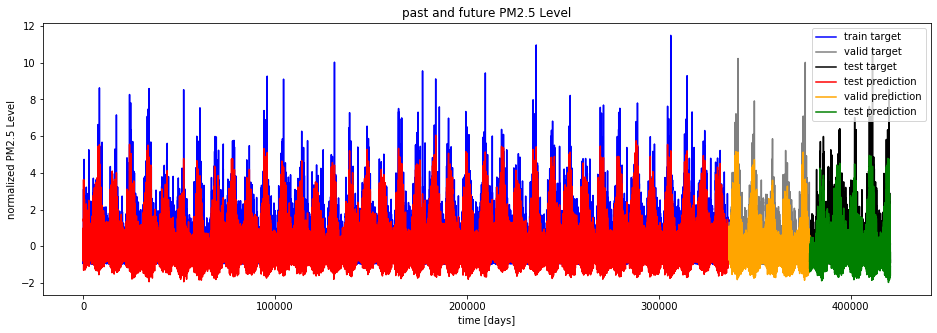

In [250]:
## show predictions
plt.figure(figsize=(35, 5));
plt.subplot(1,2,1);

plt.plot(np.arange(y_train.shape[0]), y_train[:,ft], color='blue', label='train target')

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_valid.shape[0]), y_valid[:,ft],
         color='gray', label='valid target')

plt.plot(np.arange(y_train.shape[0]+y_valid.shape[0],
                   y_train.shape[0]+y_test.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0]),y_train_pred[:,ft], color='red',
         label='test prediction')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_valid_pred.shape[0]),
         y_valid_pred[:,ft], color='orange', label='valid prediction')

plt.plot(np.arange(y_train_pred.shape[0]+y_valid_pred.shape[0],
                   y_train_pred.shape[0]+y_valid_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction')

plt.title('past and future PM2.5 Level')
plt.xlabel('time [days]')
plt.ylabel('normalized PM2.5 Level')
plt.legend(loc='best');


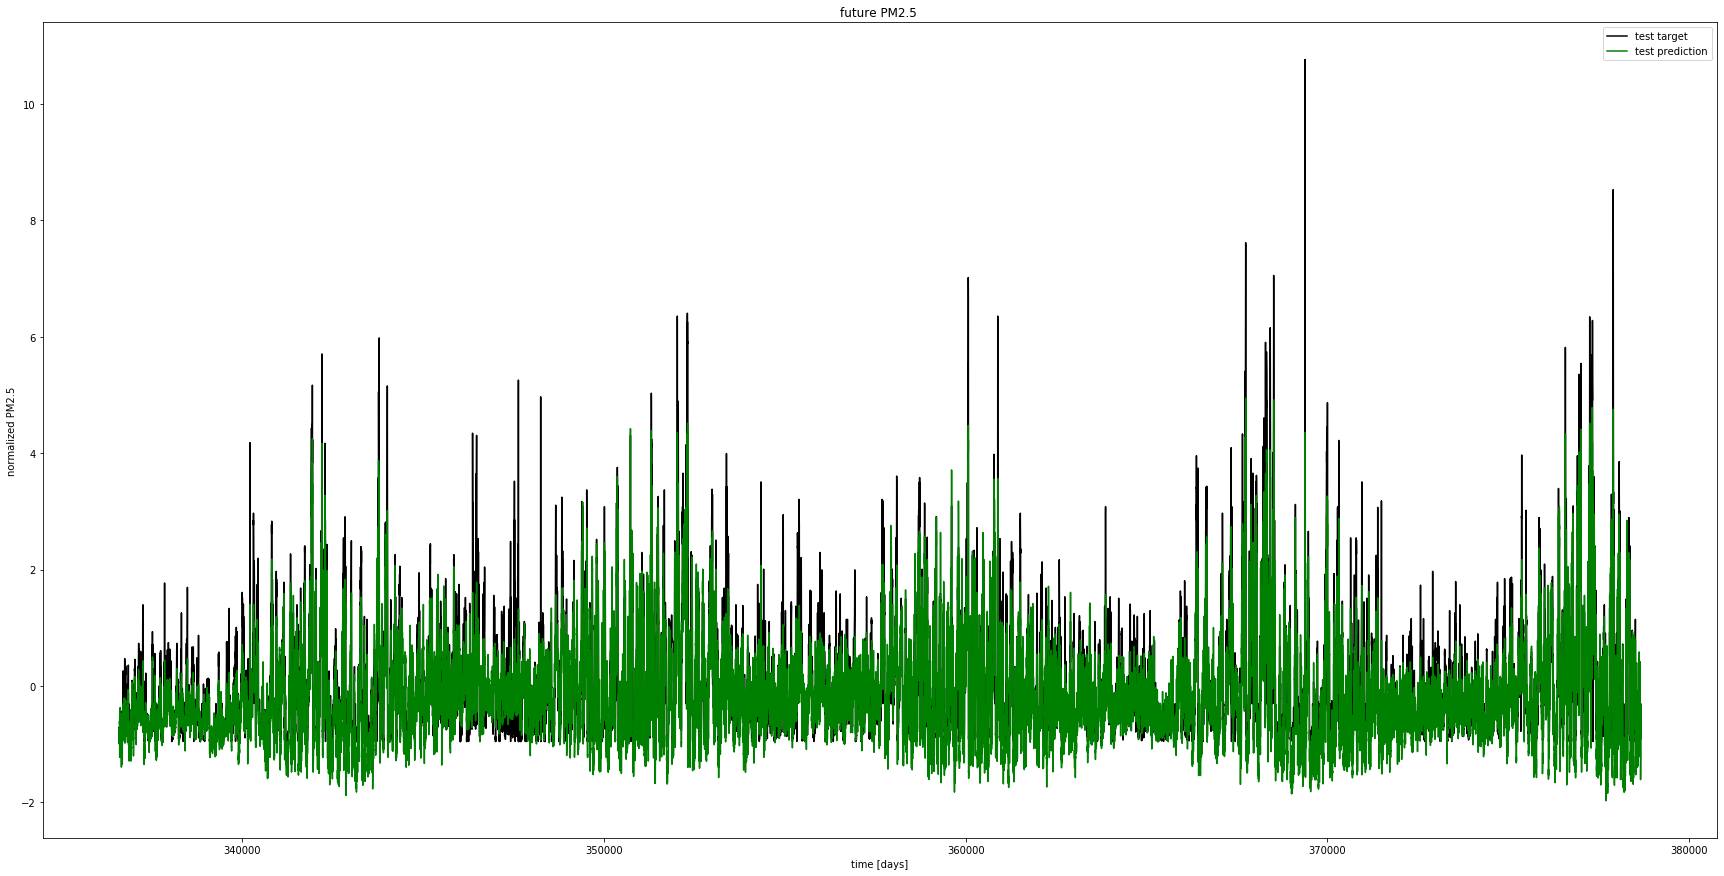

In [251]:
plt.figure(figsize=(30, 15));
plt.subplot(1,1,1);

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction')

plt.title('future PM2.5 ')
plt.xlabel('time [days]')
plt.ylabel('normalized PM2.5')
plt.legend(loc='best');

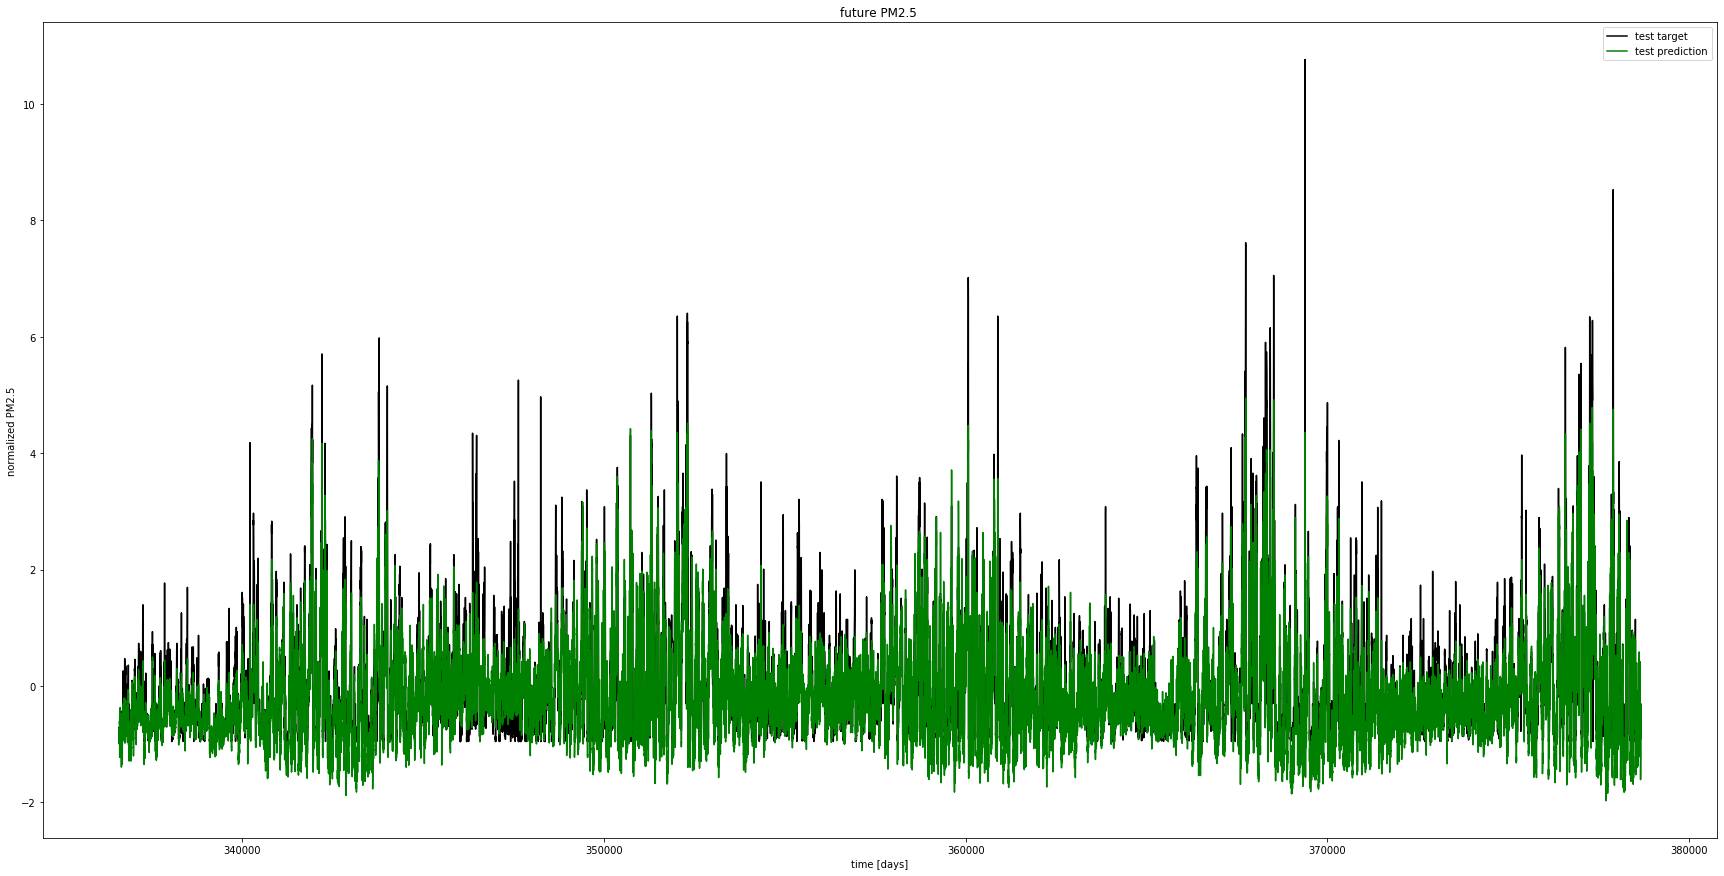

In [252]:
plt.figure(figsize=(30, 15));
plt.subplot(1,1,1);

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction')

plt.title('future PM2.5 ')
plt.xlabel('time [days]')
plt.ylabel('normalized PM2.5')
plt.legend(loc='best');

In [28]:
print('training error for', key)
print('mean_squared_error',mean_squared_error(y_train[:,4], y_train_pred[:,4]))
print('r2_score', r2_score(y_train[:,4], y_train_pred[:,4]))
print('RMSE', RMSE(y_train[:,4], y_train_pred[:,4]))

print('validation error for', key)
print('mean_squared_error',mean_squared_error(y_valid[:,4], y_valid_pred[:,4]))
print('r2_score', r2_score(y_valid[:,4], y_valid_pred[:,4]))
print('RMSE', RMSE(y_valid[:,4], y_valid_pred[:,4]))

print('test error for', key)
print('mean_squared_error',mean_squared_error(y_test[:,4], y_test_pred[:,4]))
print('r2_score', r2_score(y_test[:,4], y_test_pred[:,4]))
print('RMSE', RMSE(y_test[:,4], y_test_pred[:,4]))

training error for GRU_LSTM


NameError: name 'y_train_pred' is not defined

### Linear Regression 

In [ ]:

linearRegression=LinearRegression()
linearRegression.fit(X_train,y_train)

y_pred=linearRegression.predict(X_test)
linearRegression.score(X_test, y_test)


n_results=100
fig, ax=plt.subplots(2,1,figsize=(12,8))
ax[0].plot(y_test.values[:n_results], color="red")
ax[1].plot(y_pred[:n_results], color="green")

print('mean_squared_error',mean_squared_error(y_test, y_pred))
print('r2_score', r2_score(y_test, y_pred))
